In [1]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP2D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import AdamW, Adam #, Lion
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from PIL import Image
import numpy as np
from IPython.display import clear_output

np.random.seed(1)
tf.keras.utils.set_random_seed(1)

In [54]:
from matplotlib import pyplot as plt

def charts(history):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    axs[1].plot(history.history['acc'])
    axs[1].plot(history.history['val_acc'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    
    plt.show()

# Loading Images

In [3]:
ind_to_name = {                  # ImageNet file names \/
    0:'shark',                   # n01484850
    1:'chicken',                 # n01514859
    2:'bird',                    # n01530575
    3:'eagle',                   # n01614925
    4:'owl',                     # n01622779
    5:'lizard',                  # n01629819
    6:'turtle',                  # n01665541
    7:'wolf',                    # n02114367
    8:'lion',                    # n02129165
    9:'tiger',                   # n02129604
    10:'grizzly',                # n02132136
    11:'polar bear',             # n02134084
    12:'horse',                  # n02389026
    13:'elephant',               # n02504458
    14:'battleship/carrier'      # n02687172
}

In [4]:
imgnet_path = 'D:/ImageNet/images/'
imgs = []
y = []
for ind, files in enumerate(os.listdir(imgnet_path)):
    for ind1, img in enumerate(os.listdir(imgnet_path+files)):
        q = Image.open(imgnet_path + files + "/" + img)
        q = q.resize((224, 224)).convert('RGB')
        imgs.append(np.array(q))
        y.append(ind)
        
        print(ind, '/ 15', ind1, '/ 1300')
        clear_output(wait = True)

14 / 15 1299 / 1300


In [5]:
imgs = np.array(imgs)
imgs.shape

(19500, 224, 224, 3)

In [6]:
y = np.array(y)
y = tf.one_hot(y, 15)
y.shape

TensorShape([19500, 15])

In [7]:
indxs = np.random.rand(imgs.shape[0])<0.1

X_train, X_test, y_train, y_test = imgs[np.invert(indxs)], imgs[indxs], y[np.invert(indxs)], y[indxs]

# Creating Data Generator

In [46]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect', #'constant',
    #cval=0,
    #validation_split=0.1
    )

#datagen.fit(X_train)

# Loading The Empty Model

In [47]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=(224, 224, 3),
    classes=15)

lr_schedule = ExponentialDecay(0.01, 100, 0.95)

model.compile(optimizer=AdamW(lr_schedule),
              loss='categorical_crossentropy',
              metrics=['AUC', 'acc'])
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

# Fitting

In [48]:
#tf.config.run_functions_eagerly(True)
history = model.fit(datagen.flow(X_train, y_train,
                                 batch_size=32,
                                 shuffle=True,
                                 seed=1),
                    epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/10
549/549 [==============================] - 1093s 2s/step - loss: 2.5724 - auc: 0.7209 - acc: 0.1918 - val_loss: 2.2803 - val_auc: 0.8045 - val_acc: 0.3115
Epoch 2/10
549/549 [==============================] - 1054s 2s/step - loss: 1.8563 - auc: 0.8614 - acc: 0.3923 - val_loss: 1.6181 - val_auc: 0.8963 - val_acc: 0.4857
Epoch 3/10
549/549 [==============================] - 1051s 2s/step - loss: 1.5952 - auc: 0.8990 - acc: 0.4880 - val_loss: 1.6138 - val_auc: 0.8959 - val_acc: 0.5113
Epoch 4/10
549/549 [==============================] - 1057s 2s/step - loss: 1.3529 - auc: 0.9270 - acc: 0.5658 - val_loss: 1.2472 - val_auc: 0.9377 - val_acc: 0.5953
Epoch 5/10
549/549 [==============================] - 1051s 2s/step - loss: 1.1321 - auc: 0.9476 - acc: 0.6392 - val_loss: 1.0382 - val_auc: 0.9565 - val_acc: 0.6808
Epoch 6/10
549/549 [==============================] - 1062s 2s/step - loss: 0.9683 - auc: 0.9612 - acc: 0.6951 - val_loss: 0.8654 - val_auc: 0.9674 - val_acc: 0.7300
Epoc

In [56]:
model.save("pass_1.h5")

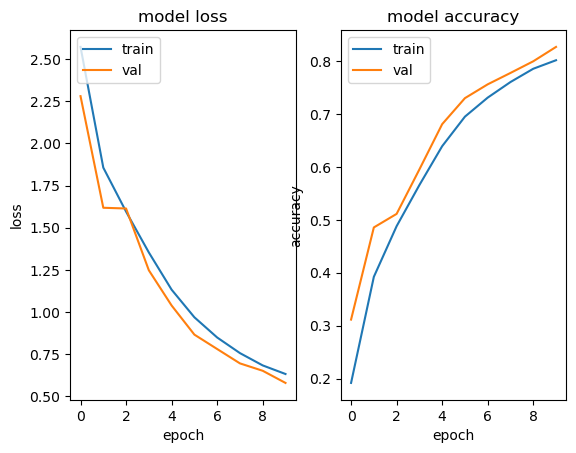

In [55]:
charts(history)

In [59]:
lr_schedule = ExponentialDecay(0.001, 1000, 0.95)
model.optimizer = AdamW(lr_schedule)

history2 = model.fit(datagen.flow(X_train, y_train,
                                 batch_size=32,
                                 shuffle=True,
                                 seed=1),
                    epochs=5,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/5
549/549 [==============================] - 1083s 2s/step - loss: 0.5857 - auc: 0.9842 - acc: 0.8162 - val_loss: 0.6152 - val_auc: 0.9824 - val_acc: 0.8217
Epoch 2/5
549/549 [==============================] - 1065s 2s/step - loss: 0.5464 - auc: 0.9863 - acc: 0.8268 - val_loss: 0.5698 - val_auc: 0.9841 - val_acc: 0.8289
Epoch 3/5
549/549 [==============================] - 1073s 2s/step - loss: 0.5140 - auc: 0.9874 - acc: 0.8381 - val_loss: 0.5285 - val_auc: 0.9854 - val_acc: 0.8489
Epoch 4/5
549/549 [==============================] - 1074s 2s/step - loss: 0.4843 - auc: 0.9886 - acc: 0.8461 - val_loss: 0.5456 - val_auc: 0.9850 - val_acc: 0.8320
Epoch 5/5
549/549 [==============================] - 1097s 2s/step - loss: 0.4670 - auc: 0.9893 - acc: 0.8537 - val_loss: 0.5263 - val_auc: 0.9855 - val_acc: 0.8407


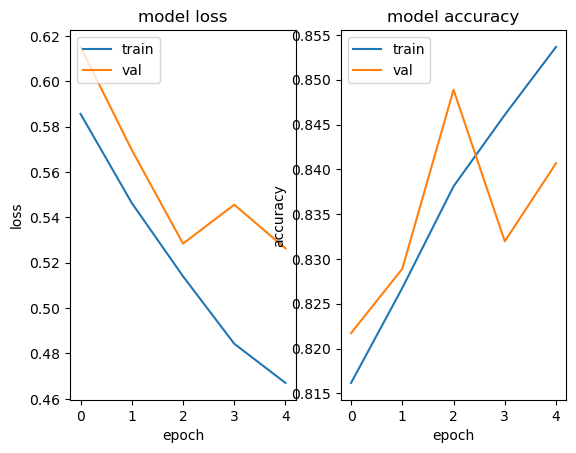

In [61]:
charts(history2)

In [62]:
model.save("pass_2.h5")

# Testing It Out

In [63]:
pred = model.predict(X_test)

61/61 [==============================] - 34s 502ms/step


In [64]:
diff = tf.math.argmax(pred, 1) != tf.math.argmax(y_test, 1)

In [65]:
X_test[diff].shape

(311, 224, 224, 3)

predicted - lion 
reality - tiger


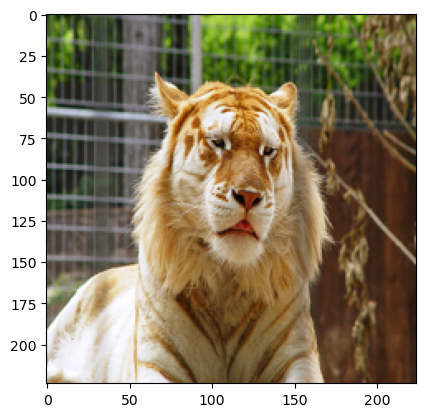

In [113]:
from matplotlib import pyplot as plt

ind = 230
plt.imshow(X_test[diff][ind])
real = tf.math.argmax(y_test, 1)[diff][ind]
pred1 = tf.math.argmax(pred, 1)[diff][ind]

print('predicted -', ind_to_name[int(pred1)], '\nreality -', ind_to_name[int(real)])

In [110]:
print('validation accuracy', 1-np.sum(diff)/np.sum(indxs))

validation accuracy 0.8406762295081968
